In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import re
import json
from pathlib import Path

import pandas as pd
import numpy as np

In [2]:
data_dir = Path("../data/geodata-stage/")

### インスタンスが独立に動作していると考え，インスタンスごと(=hostごと)にDataFrameを作成

In [5]:
instance_num = 3

instance_dict = {i: {} for i in range(1, instance_num + 1)}
json_paths = data_dir.glob("*.json")
for path in json_paths:
    with open(path, "r") as f:
        metric = path.name[:-24]
        results = json.load(f)["results"]
        metric_set = set()
        for src_data in results:
            for data in src_data["data"]:
                metric_set.add(data["metric"])
        for src_data in results:
            if src_data["source"][:10] != "summarizer":
                for data in src_data["data"]:
                    instance_id = int(re.search('\d', data["tags"]["host"]).group())
                    # jsonのキーは順番保証されていないので念の為ソート
                    tags = [data["tags"][key] for key in sorted(data["tags"].keys()) if key != "host"]
                    key_name = metric
                    # metricフィールドが全て同じならキー名に含めない
                    if len(metric_set) > 1:
                        # metricフィールドの冗長な名前を簡潔化
                        metric_attr = re.findall('^.*\.(.*)$', data['metric'])[0]
                        key_name += f"-{metric_attr}"
                    if len(tags) > 0:
                        key_name += f"-{'-'.join(tags)}"
                    instance_dict[instance_id][key_name] = data["NumericType"]

df_dict = {}
for id, instance in instance_dict.items():
    df = pd.DataFrame(instance, dtype="float32")
    df.dropna(inplace=True)
    df = df.loc[:, df.nunique() != 1] # 値が一定のメトリックを除く
    df_dict[id - 1] = df

In [6]:
df_dict[0]

,avg_cpu-usage_steal,avg_cpu-usage_nice,avg_cpu-usage_softirq,avg_cpu-usage_user,avg_cpu-usage_guest,avg_cpu-usage_irq,avg_cpu-usage_guest_nice,avg_cpu-usage_system,avg_cpu-usage_idle,avg_cpu-usage_iowait,...,avg_query_commands-insert,avg_query_commands-delete,avg_slow_query,avg_threads_connected-mysql_global_status_threads_connected,avg_threads_connected-mysql_global_status_threads_running,avg_threads_connected-mysql_global_status_max_used_connections,disk_usage_(data_volume)___binlog_file_total_size-total-vdb,disk_usage_(data_volume)___binlog_file_total_size-used-vdb,disk_usage_(percent)-vdb,disk_usage_(percent)-vda2
1,0.013638,0.0,1.940564,18.081873,0.0,0.0,0.0,6.852520,71.713745,1.397663,...,0.547407,367.088226,0.062222,863.333313,3.066667,1305.0,2.575722e+11,6.924573e+10,26.884007,66.188545
2,0.010479,0.0,1.167873,11.359351,0.0,0.0,0.0,3.982474,82.907555,0.572267,...,0.569259,289.076294,0.004444,863.599976,2.066667,1305.0,2.575722e+11,6.922563e+10,26.876202,65.906746
3,0.010375,0.0,1.199822,12.850615,0.0,0.0,0.0,4.028460,80.848816,1.061911,...,0.594296,410.548218,0.008889,867.799988,2.000000,1305.0,2.575722e+11,6.930478e+10,26.906933,65.954124
4,0.013796,0.0,2.156995,18.705482,0.0,0.0,0.0,7.070439,70.885391,1.167894,...,0.674370,390.774231,0.057778,863.266663,2.666667,1305.0,2.575722e+11,6.938952e+10,26.939833,65.972160
5,0.011314,0.0,2.033064,16.728069,0.0,0.0,0.0,6.529066,73.859932,0.838553,...,0.905259,403.188751,0.000000,867.799988,3.933333,1305.0,2.575722e+11,6.935186e+10,26.925209,65.984299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.010484,0.0,1.413114,12.087495,0.0,0.0,0.0,4.583874,81.344887,0.560144,...,0.226370,244.495926,0.000000,859.266663,2.200000,1305.0,2.575722e+11,6.923042e+10,26.878063,65.589447
91,0.012091,0.0,0.939494,10.856964,0.0,0.0,0.0,3.403129,83.801727,0.986599,...,0.817630,371.650818,0.000000,864.400024,2.133333,1305.0,2.575722e+11,6.921657e+10,26.872684,65.637779
92,0.014114,0.0,2.046517,16.984226,0.0,0.0,0.0,6.706999,72.653564,1.594580,...,0.833481,240.271927,0.066667,866.400024,3.466667,1305.0,2.575722e+11,6.927060e+10,26.893661,65.676773
93,0.010293,0.0,0.602861,8.973313,0.0,0.0,0.0,2.274602,87.244118,0.894813,...,0.985704,288.643097,0.004444,861.599976,1.733333,1305.0,2.575722e+11,6.925447e+10,26.887402,65.690170


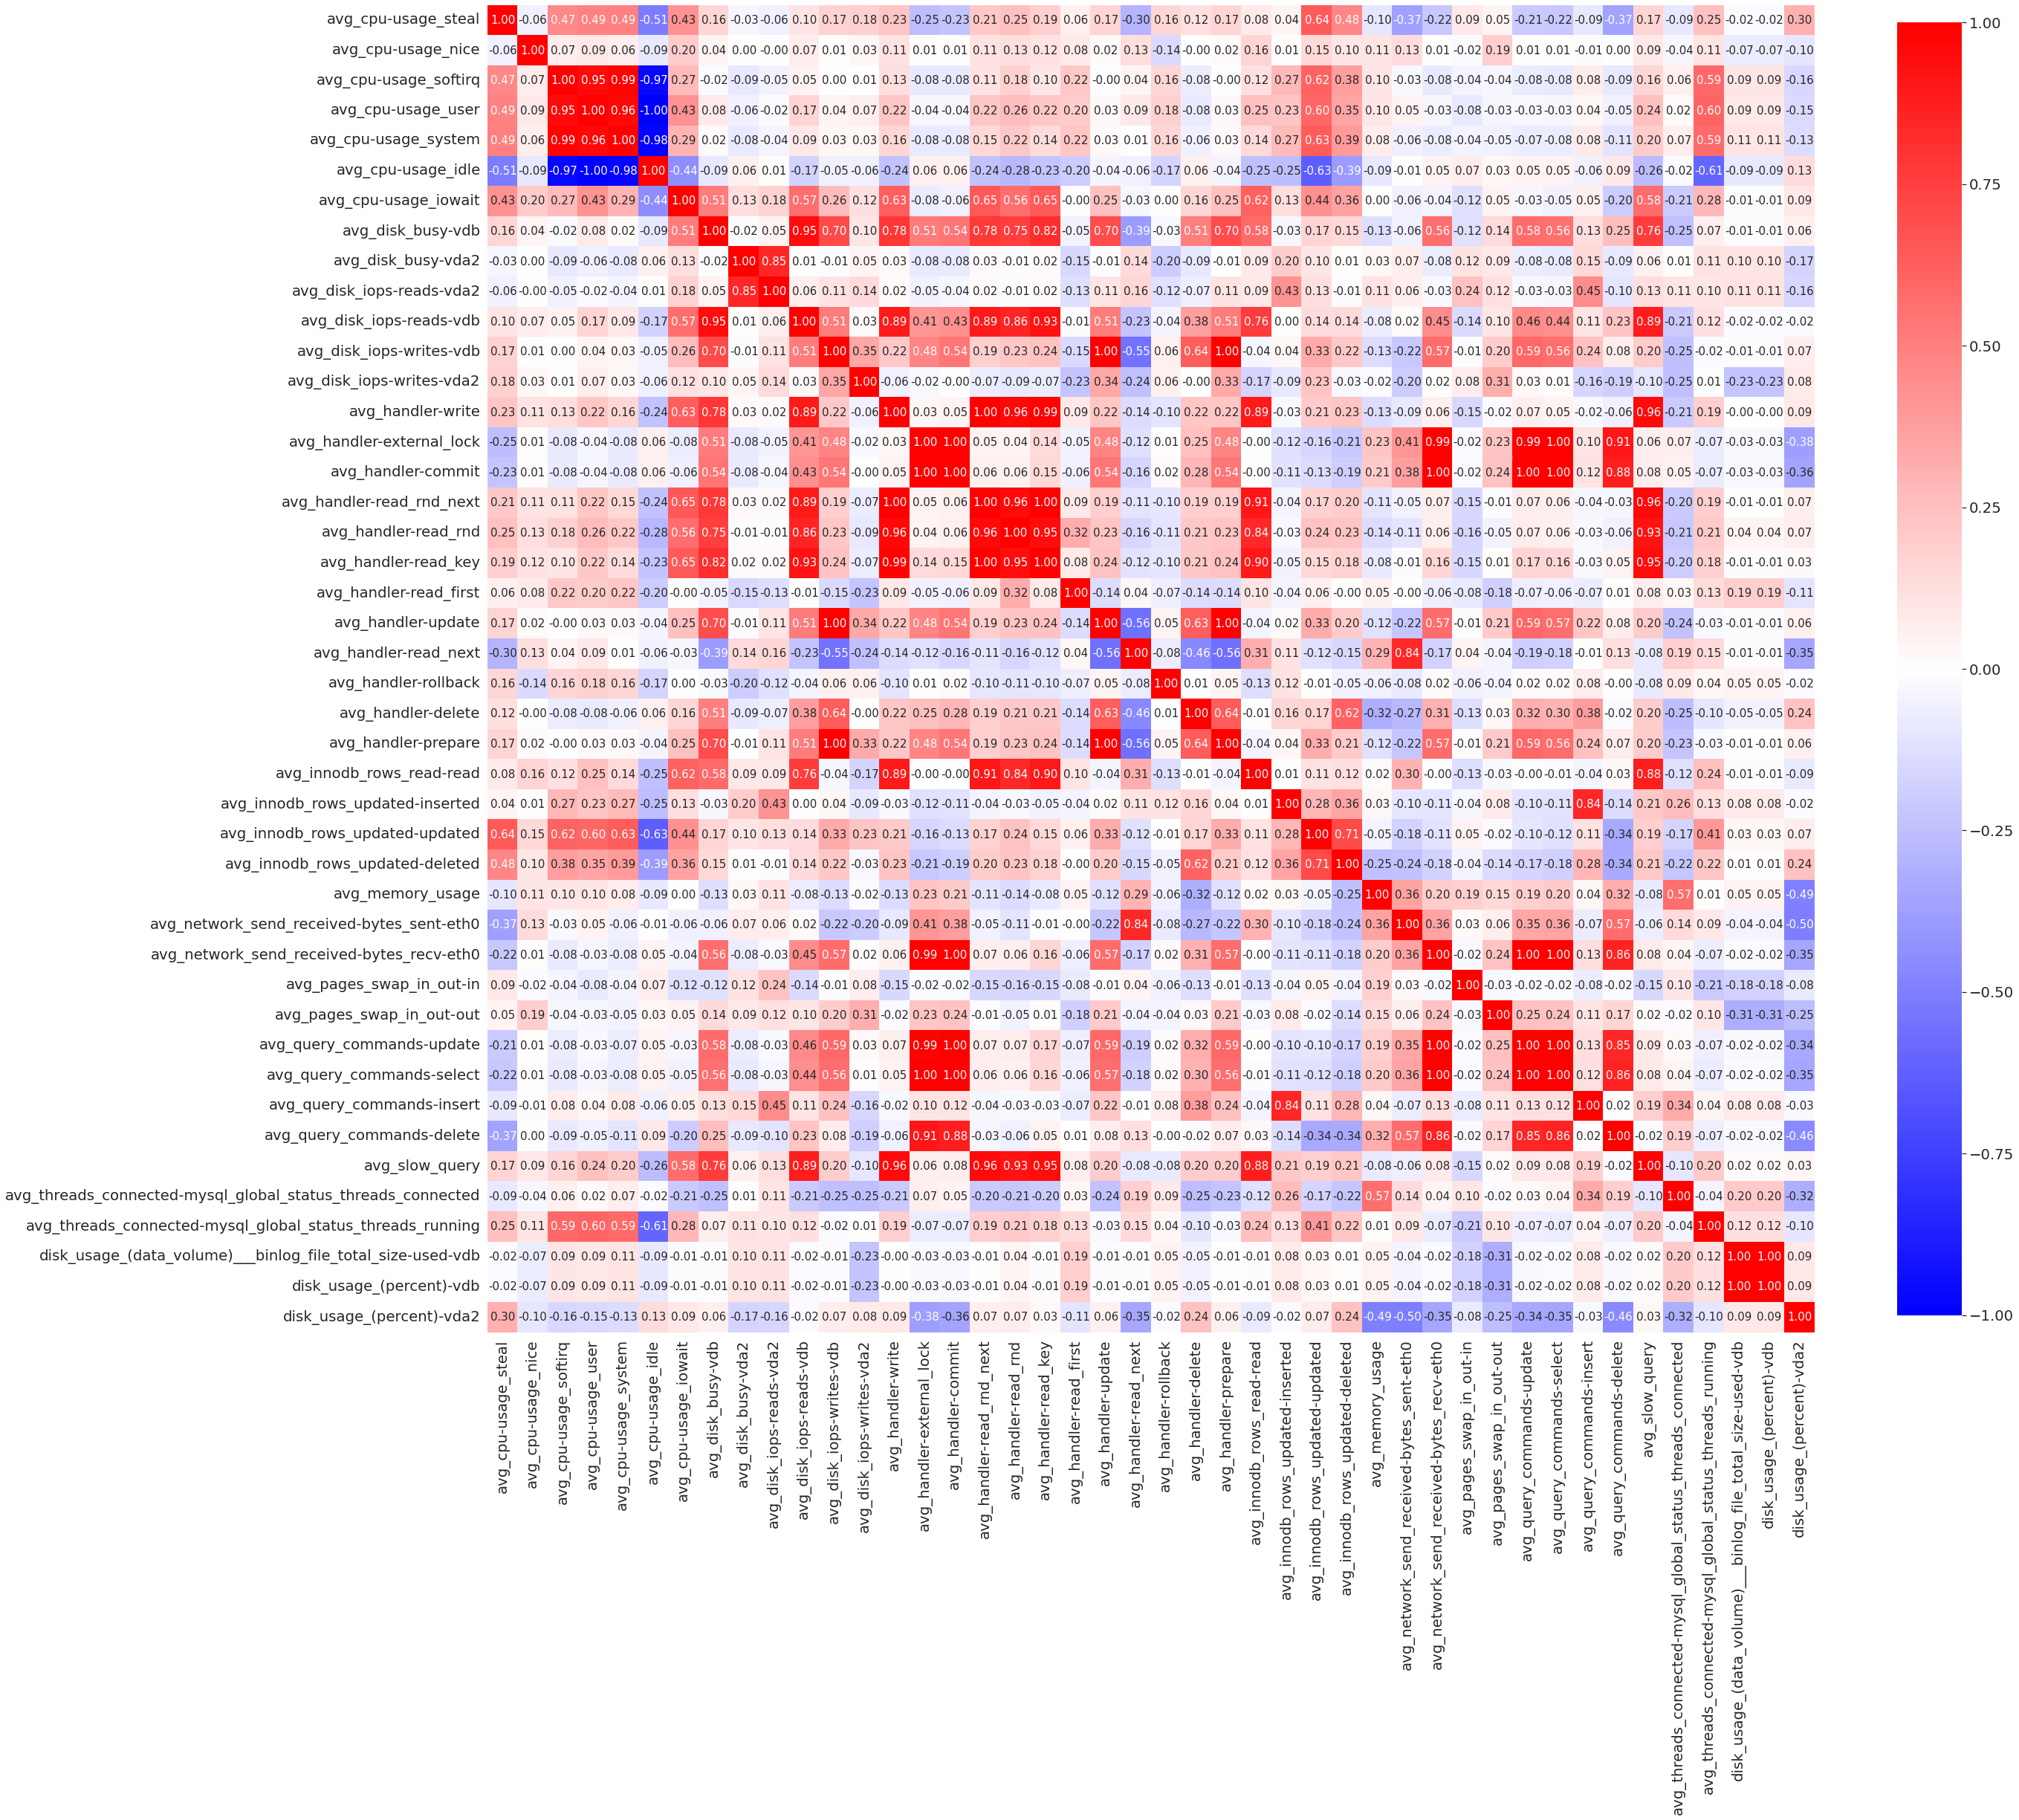

In [7]:
# 値が一定のメトリックを除いて分析
df = df_dict[0]
df = df.loc[:, df.nunique() != 1]

sns.set(font_scale=1.8)
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.show()

In [8]:
from pprint import pprint

### 閾値を徐々に下げて削除していく
これにより相関が非常に高いものを優先的に削除できる

In [ ]:
df = df_dict[0]

['avg_handler-write',
 'avg_handler-external_lock',
 'avg_cpu-usage_softirq',
 'avg_handler-commit',
 'avg_handler-read_rnd_next',
 'avg_cpu-usage_user',
 'avg_disk_iops-writes-vdb',
 'avg_network_send_received-bytes_recv-eth0',
 'avg_cpu-usage_system',
 'avg_disk_busy-vdb',
 'avg_handler-read_key',
 'avg_handler-update',
 'disk_usage_(data_volume)___binlog_file_total_size-used-vdb',
 'avg_handler-read_rnd',
 'avg_slow_query',
 'avg_disk_busy-vda2',
 'avg_handler-read_next',
 'avg_innodb_rows_updated-inserted',
 'avg_disk_iops-reads-vdb',
 'avg_innodb_rows_updated-updated']


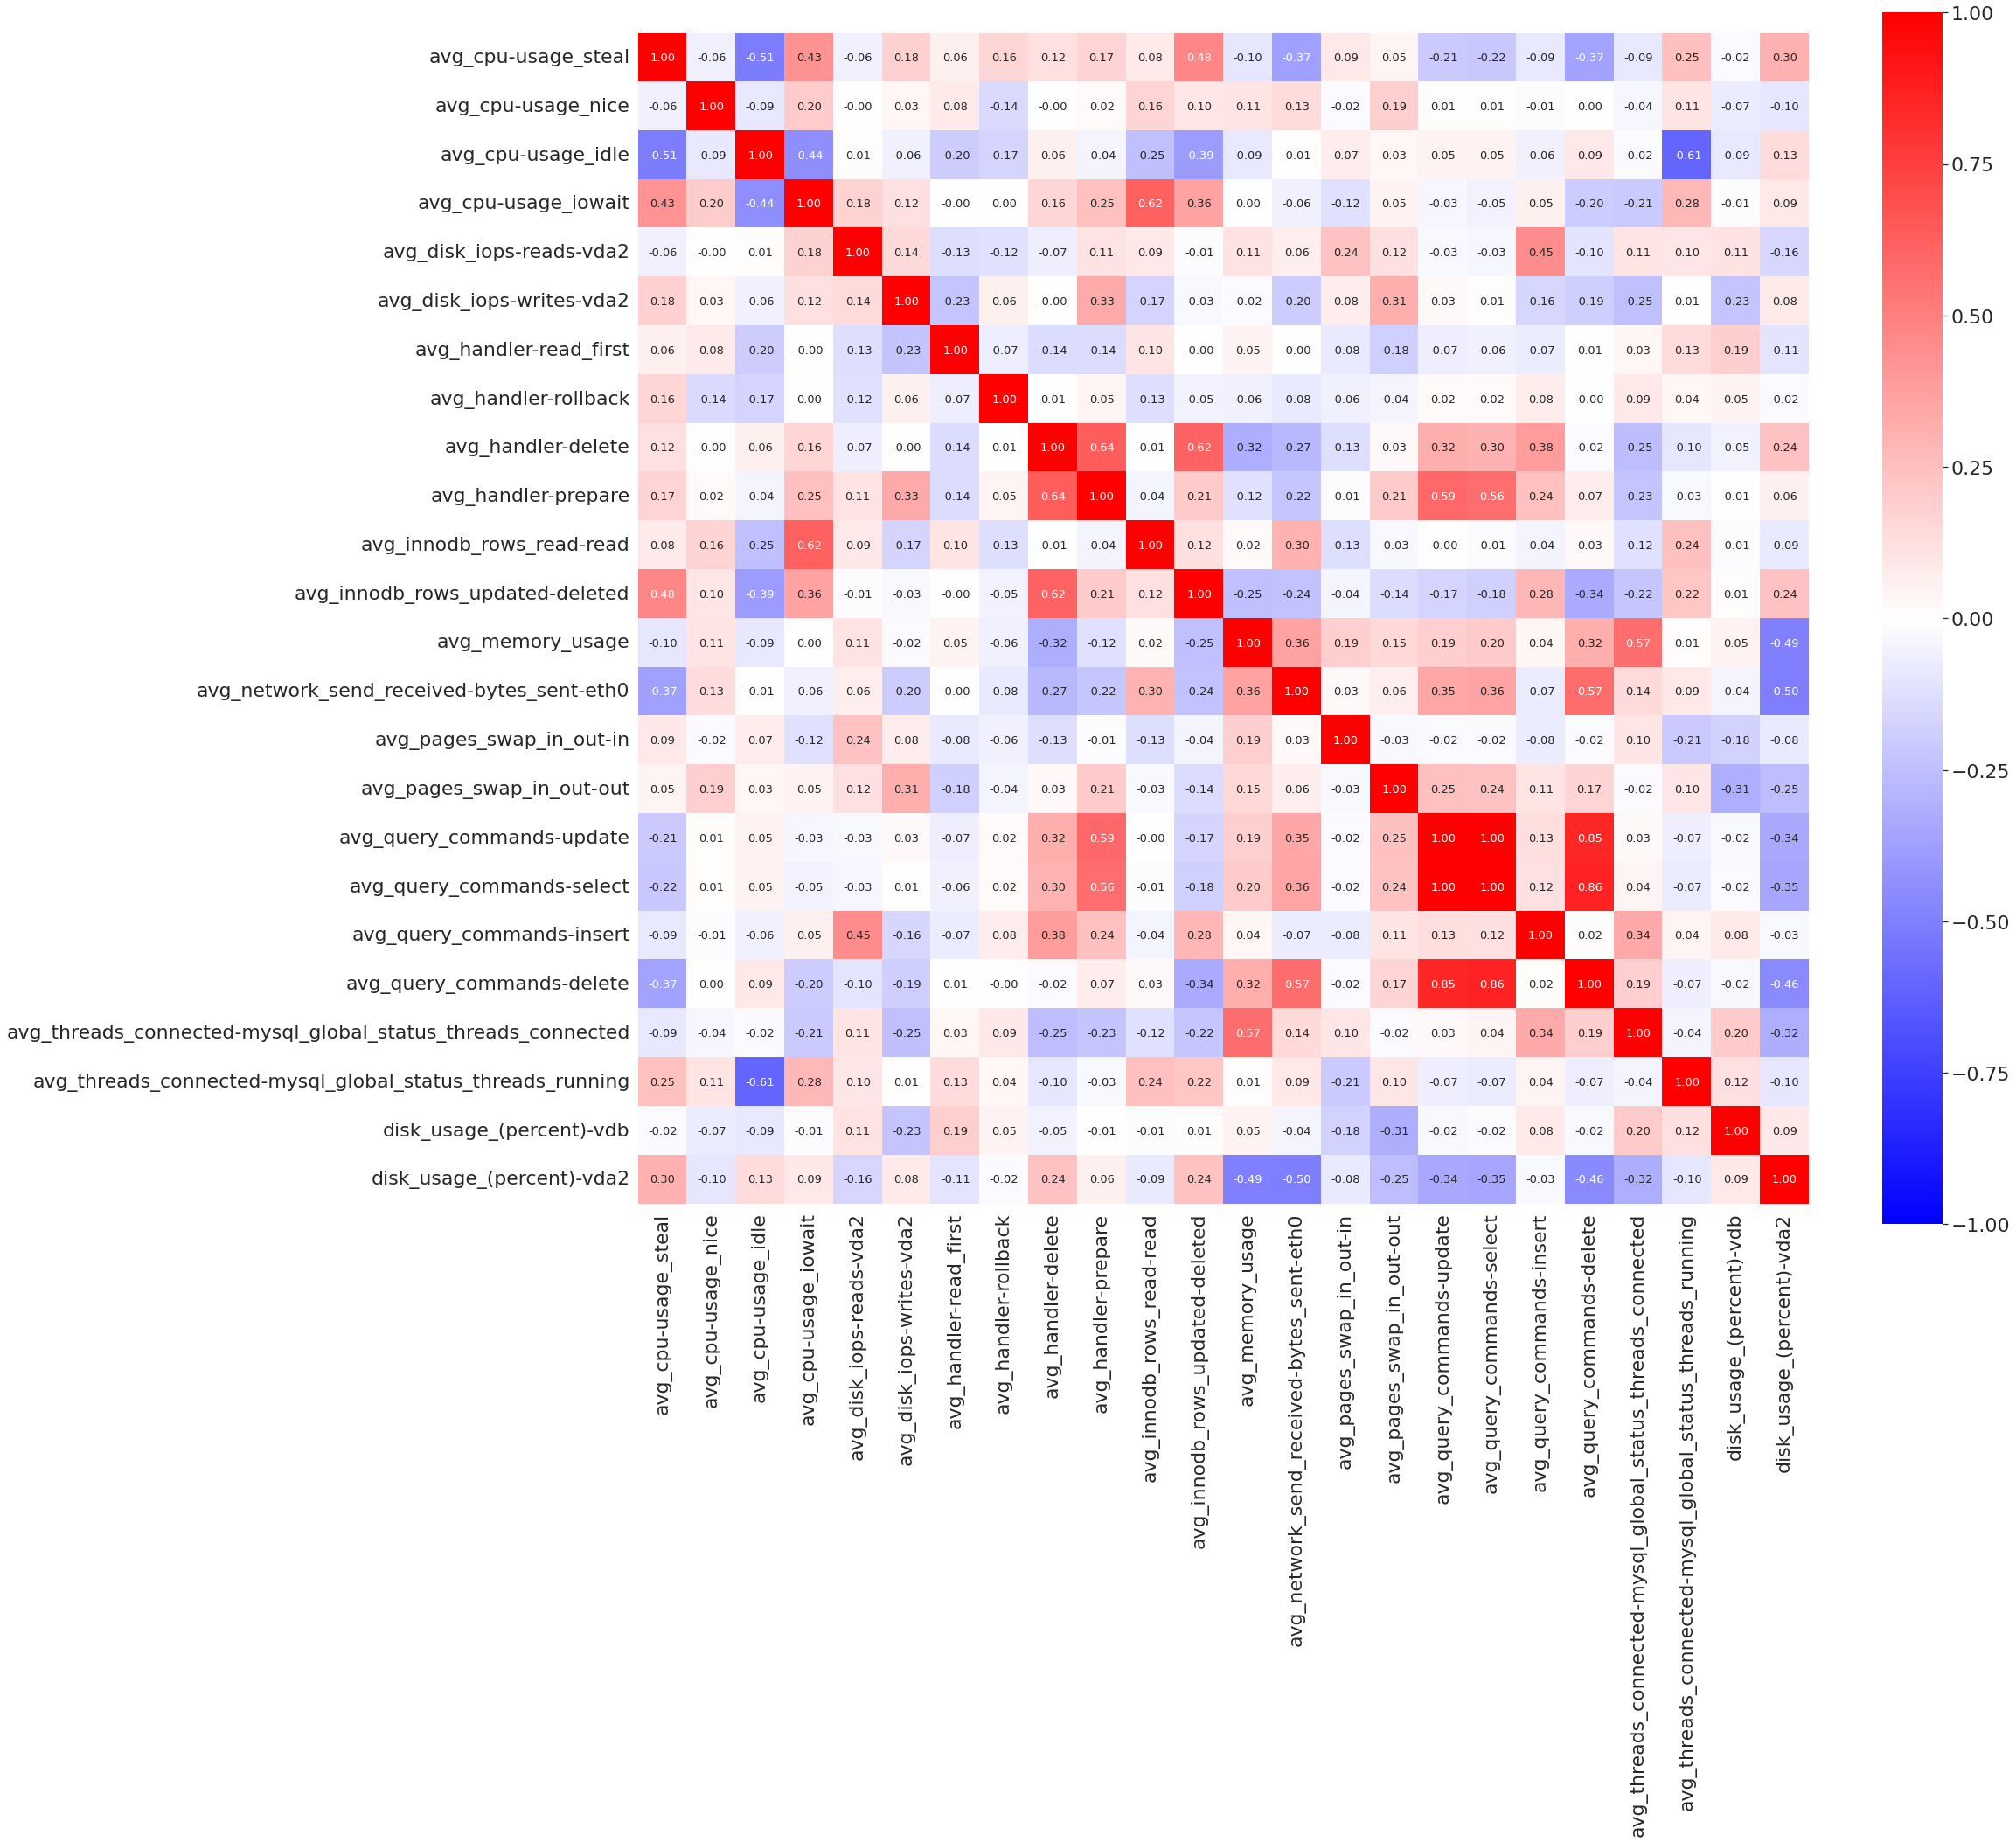

['avg_handler-commit',
 'avg_cpu-usage_softirq',
 'avg_handler-external_lock',
 'avg_cpu-usage_user',
 'avg_disk_iops-writes-vdb',
 'avg_handler-read_key',
 'avg_network_send_received-bytes_recv-eth0',
 'avg_cpu-usage_system',
 'avg_handler-update',
 'avg_handler-write',
 'disk_usage_(data_volume)___binlog_file_total_size-used-vdb',
 'avg_handler-read_rnd_next',
 'avg_disk_iops-reads-vdb',
 'avg_disk_busy-vda2',
 'avg_slow_query',
 'avg_innodb_rows_updated-inserted',
 'avg_handler-read_rnd',
 'avg_handler-read_next',
 'avg_innodb_rows_updated-updated']


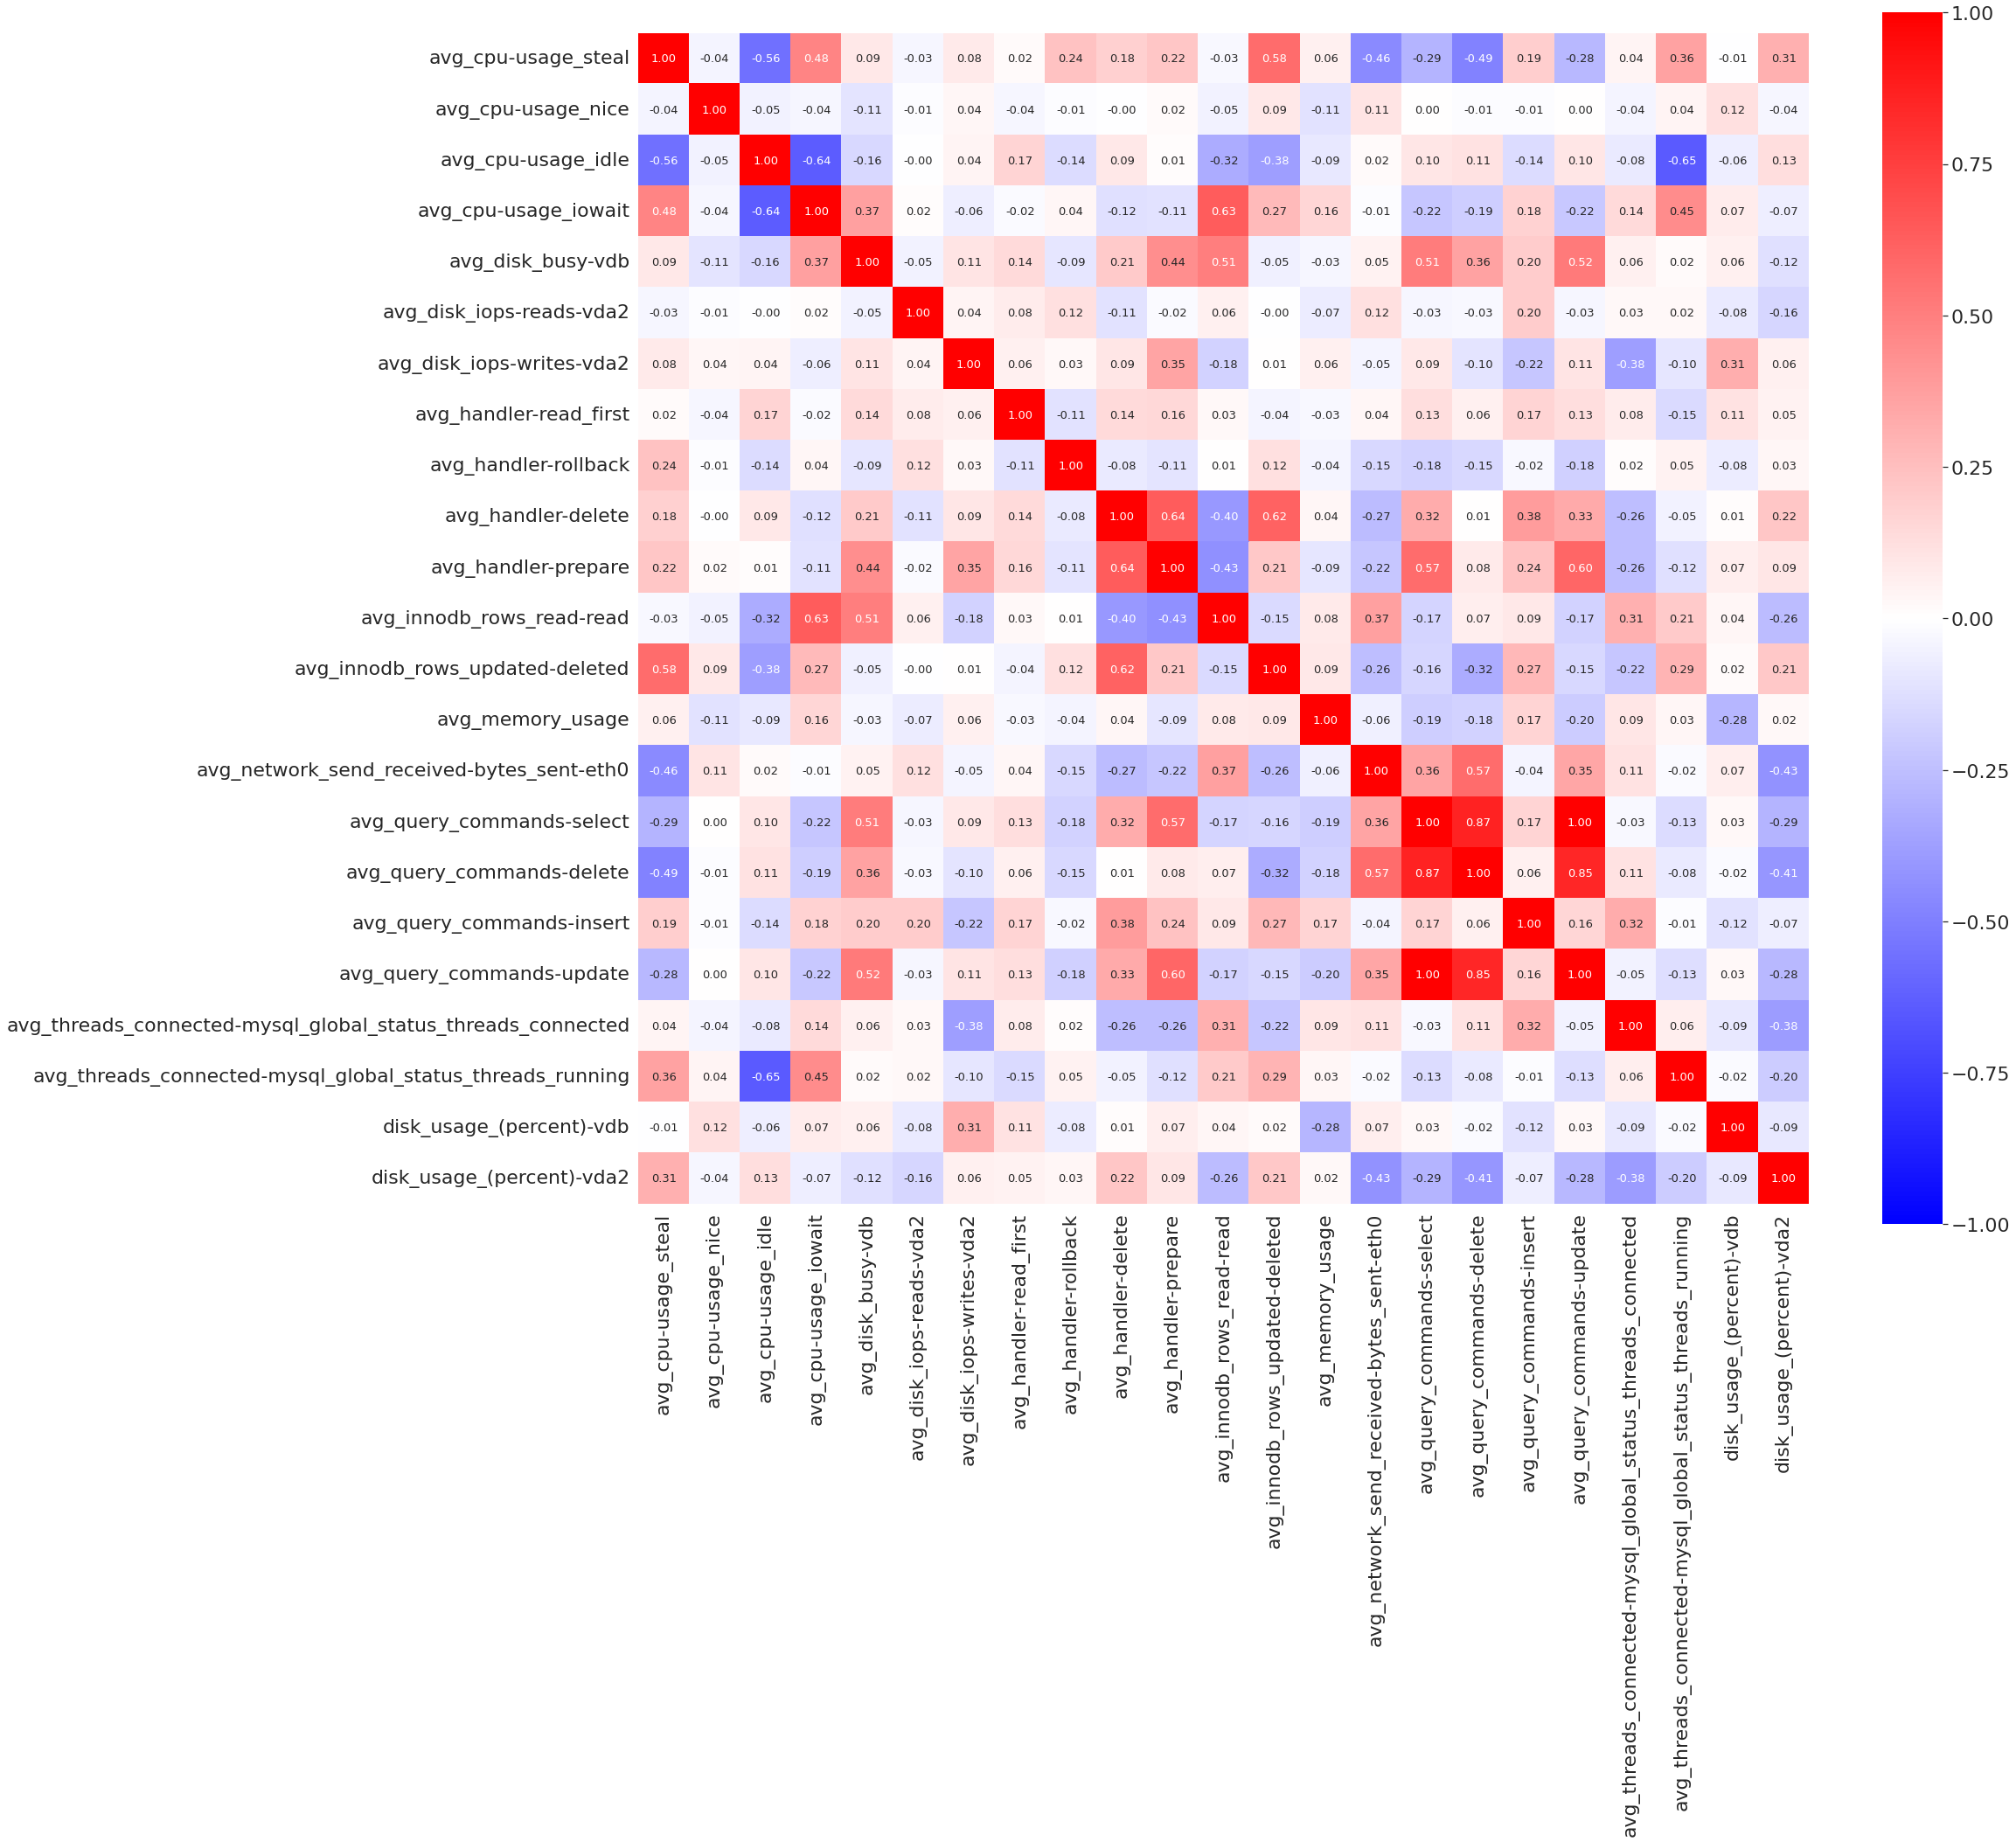

['avg_disk_busy-vdb',
 'avg_disk_iops-writes-vdb',
 'avg_handler-prepare',
 'avg_handler-commit',
 'avg_handler-read_key',
 'avg_handler-read_rnd',
 'avg_handler-update',
 'avg_handler-external_lock',
 'avg_cpu-usage_softirq',
 'avg_disk_iops-reads-vdb',
 'avg_handler-read_rnd_next',
 'avg_handler-delete',
 'avg_innodb_rows_read-read',
 'disk_usage_(data_volume)___binlog_file_total_size-used-vdb',
 'avg_cpu-usage_user',
 'avg_handler-write',
 'avg_innodb_rows_updated-inserted',
 'avg_cpu-usage_steal',
 'avg_cpu-usage_idle',
 'avg_disk_busy-vda2',
 'avg_handler-read_first',
 'avg_cpu-usage_system',
 'avg_cpu-usage_iowait',
 'avg_innodb_rows_updated-updated']


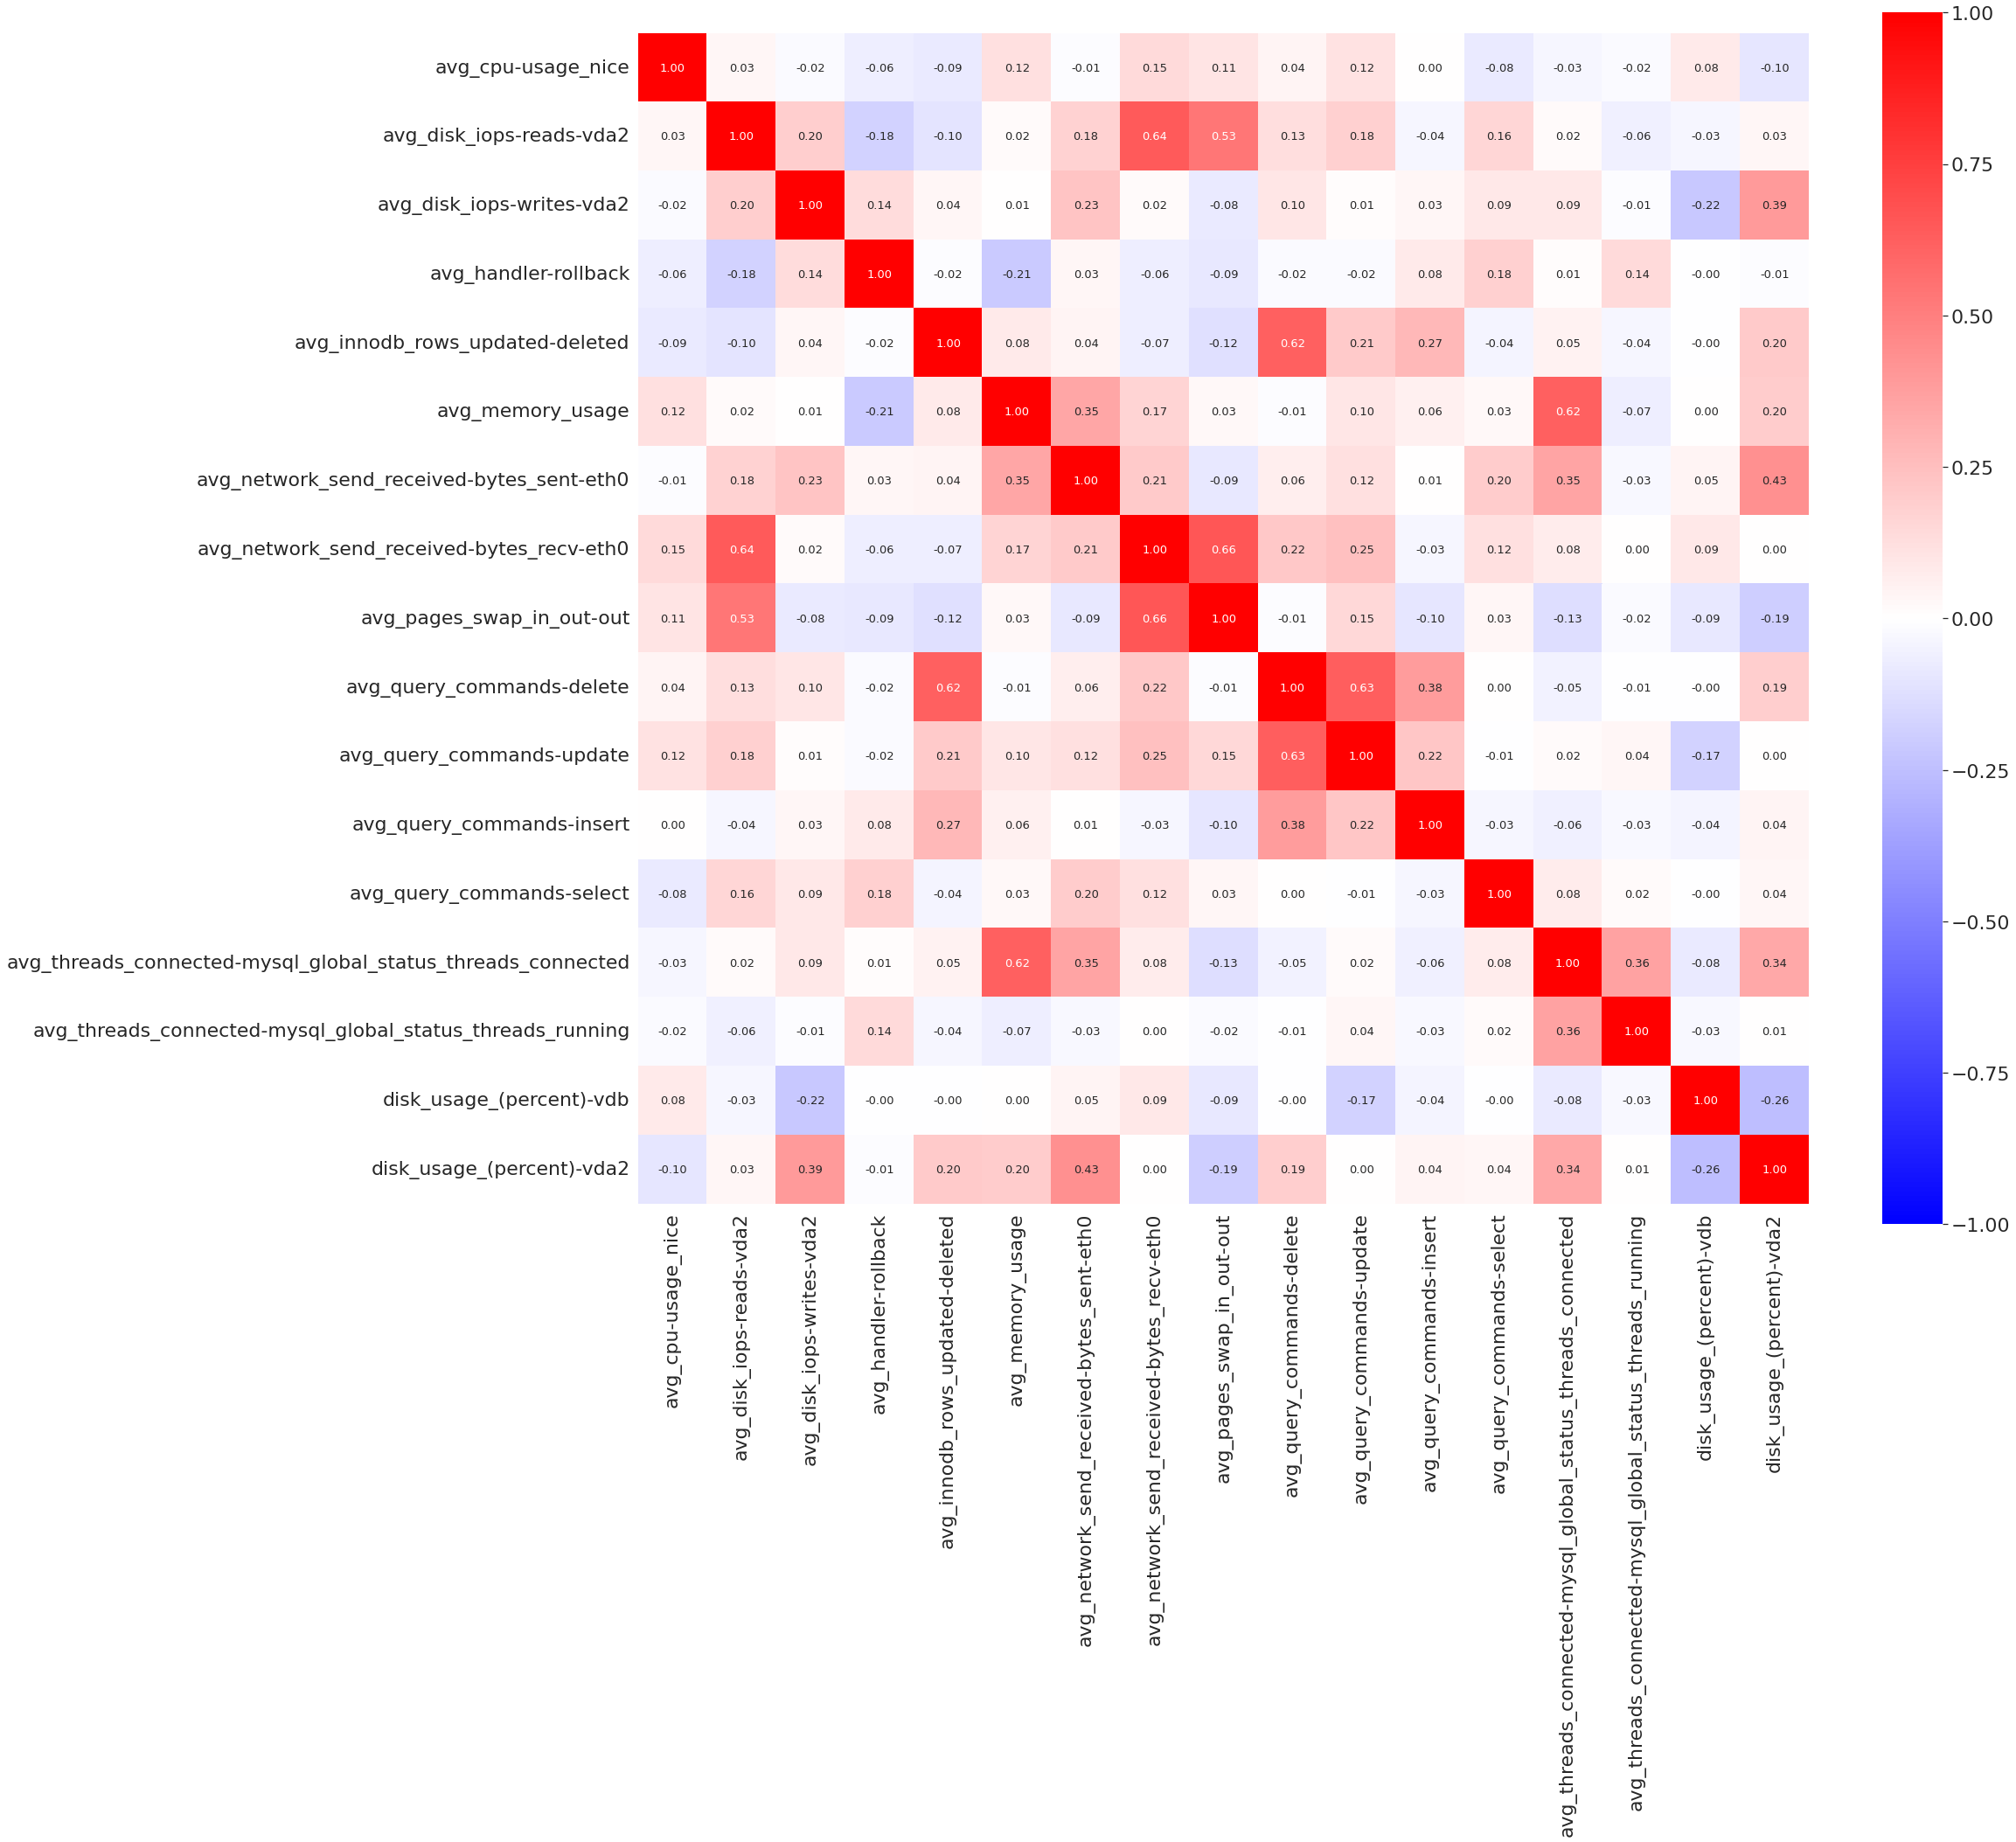

In [15]:
sns.set(font_scale=2)
for df in df_dict.values():
    df = df.loc[:, df.nunique() != 1]
    df_selected = df.copy()
    del_lim = 25
    del_num = 0
    ths = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
    del_metrics_all = []
    
    for th in ths:
        df_corr = df_selected.corr()
        corr_mat = df_corr.to_numpy()
        cols = df_corr.columns

        # 相関が th 以上 or -th 以下のメトリックを取り出す
        high_corrs_dict = {k: set() for k in cols}
        for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
            if i < j:
                # queryはworkloadを最もよく表しているので，消さないようにする
                if cols[i][:9] != "avg_query":
                    high_corrs_dict[cols[i]].add(cols[j])
                if cols[j][:9] != "avg_query":
                    high_corrs_dict[cols[j]].add(cols[i])
        del_metrics = []
        while del_num < del_lim:
            # 相関が高いメトリック間の関係数をメトリック別に列挙
            # （メトリックごとの関係数を相関係数の和で代用してもいい）
            del_metric = max(high_corrs_dict.items(), key=lambda item: len(item[1]))[0]
            if len(high_corrs_dict[del_metric]) == 0:
                break
            # keyを削除
            high_corrs_dict.pop(del_metric, None)
            # value(=set)の要素を削除
            for k, v_set in high_corrs_dict.items():
                if del_metric in v_set:
                    v_set.discard(del_metric)
            del_metrics.append(del_metric)
            del_num += 1
        del_metrics_all += del_metrics
        df_selected.drop(del_metrics, axis=1, inplace=True)
    pprint(del_metrics_all)
    plt.figure(figsize=(30, 30))
    sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 13}, fmt=".2f", cbar_kws={"shrink": 0.85})
    plt.show()